# Libraries

In [1]:
import zarr as zr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import soundfile as sf # https://pysoundfile.readthedocs.io/
import sounddevice as sd # https://python-sounddevice.readthedocs.io/
import pyaudio # https://people.csail.mit.edu/hubert/pyaudio/docs

#from tqdm import tqdm
from tqdm.auto import tqdm  # notebook compatible

import concurrent.futures
import time
import sys
import scipy.signal
import spectrum

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utility

In [80]:
def plot_array(x, y, text='(x,y)', title='', xlabel='', ylabel='', stem=False):
  fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

  if(stem):
    fig.add_trace(
        go.Scatter(x=x, y=y, text=text, name='analog', mode='markers', marker=dict(size=5, line=dict(width=1))),
        row=1, col=1
    )
  else:
    fig.add_trace(
        go.Scatter(x=x, y=y, text=text, name='analog'),
        row=1, col=1
    )
  fig.update_layout(height=320, width=640, title_text=title)
  fig.update_yaxes(title_text=ylabel, showgrid=True)
  fig.update_xaxes(title_text=xlabel, showgrid=True)
  fig.show()

def chunked_pcolormesh(t, f, S):
    fig = plt.figure(dpi=100)
    ax = plt.axes()

    slice_shape = S.shape[1]
    slice_chunks = S.chunks[1]

    m = int(np.floor(slice_shape/slice_chunks))
    #n = slice_shape-m*slice_chunks

    for i in range(m+1): 
        ax.pcolormesh(t[i*slice_chunks:(i+1)*slice_chunks], f, S[:,i*slice_chunks:(i+1)*slice_chunks], shading='gouraud', vmin=1e-12, vmax=1e-4)
    
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    #fig.savefig('foo.jpg')

In [83]:
class Params:
    def __init__(self, tapers=[3,5], pad=0, Fs=1, fpass=None, err=0, trialave=0):
        self.tapers = tapers
        self.pad = pad
        self.Fs = Fs
        if fpass==None: self.fpass = [0, Fs/2]
        else: self.fpass = fpass
        self.err = err
        self.trialave = trialave
    
    def getparams(self):
        return self.tapers, self.pad, self.Fs, self.fpass, self.err, self.trialave

def mtfftc(data, tapers, nfft, Fs):
    data = data.ravel()

    NC = len(data)
    C = 1
    NK, K = tapers.shape[0], tapers.shape[1]
    tapers = np.repeat(tapers[:, :, np.newaxis], C, axis=2)
    data = np.repeat(data.reshape(-1,1)[:, :, np.newaxis], K, axis=2)
    data = np.transpose(data, (0,2,1))
    data_prof = data * tapers
    J = np.fft.fft(data_prof, n=int(nfft), axis=0)/Fs

    return J

def mtspectrumc(data, params):
    tapers, pad, Fs, fpass, err, trialave = params.getparams()

    data = data.ravel()
    N = len(data)
    nfft = np.maximum(2**(np.ceil(np.log2(np.abs(N)))+pad), N)

    df = Fs/nfft
    f = np.arange(0, Fs+1, df)[0:int(nfft)]
    if len(fpass)!=1:
        findx = np.where((f>=fpass[0]) & (f<=fpass[-1]),True,False)
    else:
        pass
    f = f[findx]

    sz = len(tapers)
    tapers, eigs = spectrum.dpss(N,tapers[0],tapers[1])
    tapers = tapers * np.sqrt(Fs)
    #params.tapers = tapers

    J = mtfftc(data, tapers, nfft, Fs)
    J = J[findx,:,:]
    S = np.mean(np.conj(J)*J, axis=1)
    S = np.squeeze(S)
    #S = np.transpose(np.expand_dims(S, axis=3), (0,2,1))
    # if trialave: np.squeeze(np.mean(S, axis=1))
    # else: S = np.squeeze(S)

    return S, f


def mtspecgramc(data, movingwin, params):
    tapers, pad, Fs, fpass, err, trialave = params.getparams()
    
    data = data.ravel()
    N = len(data)
    Ch = 1
    Nwin = np.round(Fs*movingwin[0])
    Nstep = np.round(Fs*movingwin[1])
    nfft = np.maximum(2**(np.ceil(np.log2(np.abs(Nwin)))+pad), Nwin)

    df = Fs/nfft
    f = np.arange(0, Fs, df)[0:int(nfft)]
    if len(fpass)!=1:
        findx = np.where((f>=fpass[0]) & (f<=fpass[-1]),True,False)
    else:
        pass
    f = f[findx]
    Nf = len(f)

    #sz = len(tapers)
    #tapers, eigs = spectrum.dpss(int(Nwin),tapers[0],tapers[1])
    #tapers = tapers * np.sqrt(Fs)

    winstart = np.arange(1, N-Nwin+1, Nstep, dtype=int)
    nw = len(winstart)

    #if trialave: S = np.zeros((nw,Nf), dtype=np.complex128)
    #else: S = np.zeros((nw,Nf,Ch), dtype=np.complex128)
    # if trialave: S = np.zeros((nw,Nf))
    # else: S = np.zeros((nw,Nf,Ch))

    S = zr.zeros((int(Nf), int(nw)), chunks=(int(Nf), int(Nstep)), dtype='float32')
    for n in range(nw):
        indx = np.arange(winstart[n], winstart[n]+Nwin, 1, dtype=int)
        datawin = data[indx]
        s, _ = mtspectrumc(datawin, params)
        S[:,n] = np.abs(s.ravel()).astype(np.float32)

    winmid = winstart+np.round(Nwin/2)
    t = winmid/Fs

    return S, zr.array(t.ravel(), chunks=(int(Nwin))), zr.array(f.ravel(), chunks=(int(Nf)))    
    
# must use around a if __name__ == '__main__'
# with tqdm(total=nw) as pbar:
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             futures = []
#             for n in range(nw):
#                 indx = np.arange(winstart[n], winstart[n]+Nwin, 1, dtype=int)
#                 datawin = data[indx]
#                 futures.append(
#                     executor.submit(
#                         in_thread_loop, datawin=datawin, params=params, n=n)
#                 )
#             for future in concurrent.futures.as_completed(futures):
#                 S[future.result()[1],:] = future.result()[0]
#                 pbar.update(1)

In [84]:
wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/data/"
data, fs = sf.read(file = wd+"usv_audio.wav")

In [85]:
params = Params(tapers = [7, 11], Fs=250000, pad=0, fpass=[0, 250000/2], trialave=0, err=[0, 0.05])
movingwin = [0.01, 0.001/2]
S, t, f = mtspecgramc(data.ravel(), movingwin, params)
S[:] = (S-np.min(S))/(np.max(S)-np.min(S))

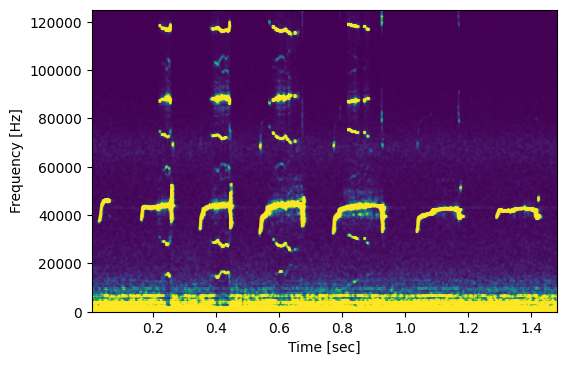

In [86]:
chunked_pcolormesh(t, f, S)

In [78]:
print(f"Memory consumption:")
print(f"Audio file: %f MB" % (data.nbytes/1024**2))
print(f"Spectrogram: %f MB" % (S.nbytes/1024**2))

Memory consumption:
Audio file: 2.834938 MB
Spectrogram: 11.544697 MB
